In [77]:

from kevlib import common_import_script
%run $common_import_script
from astropy.coordinates import SkyCoord
from astroscrappy import detect_cosmics
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
import lmfit
from astropy.io import fits
from kevlib.utils.plot import plot_images
from glob import glob
import kevlib.image as kli
from kevlib.utils import fix_byte_order
import urllib.parse
from astropy.io import ascii as astro_ascii
from scipy.ndimage import binary_dilation, binary_erosion
import shapely
from shapely.geometry import Polygon, Point

def is_point_inside_bounding_area(bounding_points, point_to_check):
    polygon = Polygon(bounding_points)
    
    point = Point(point_to_check)
    
    return polygon.contains(point)

---------------------------------------------------------------------------------------
|                        Last run date: 2025-06-11 07:41 PM E                         |
---------------------------------------------------------------------------------------
| Python | Jupyterlab | Numpy  | Scipy  | Astropy | Matplotlib | Tensorflow | Pytorch |
---------------------------------------------------------------------------------------
| 3.11.4 |   4.1.2    | 1.24.3 | 1.11.1 |  5.3.1  |   3.8.3    |   2.13.1   |  2.0.1  |
---------------------------------------------------------------------------------------


In [78]:
import numpy as np

def find_patterns(image):
    target_value = 268435456

    height, width = image.shape
    mask_image = np.zeros((height, width), dtype=int)

    for y in range(height - 1):
        for x in range(width - 1):
            if (image[y, x] == target_value and
                image[y, x + 1] == target_value and
                image[y + 1, x] == target_value and
                image[y + 1, x + 1] == target_value):
                
                mask_image[y, x] = 1
                mask_image[y, x + 1] = 1
                mask_image[y + 1, x] = 1
                mask_image[y + 1, x + 1] = 1

            if (image[y, x] == target_value and
                image[y + 1, x + 1] == target_value):
                mask_image[y, x] = 1
                mask_image[y + 1, x + 1] = 1

            if (image[y, x + 1] == target_value and
                image[y + 1, x] == target_value):
                mask_image[y, x + 1] = 1
                mask_image[y + 1, x] = 1

            if image[y, x] == target_value and image[y + 1, x] == target_value:
                mask_image[y, x] = 1
                mask_image[y + 1, x] = 1

            if image[y, x] == target_value and image[y, x + 1] == target_value:
                mask_image[y, x] = 1
                mask_image[y, x + 1] = 1

    for y in range(height - 1):
        if image[y, width - 1] == target_value and image[y + 1, width - 1] == target_value:
            mask_image[y, width - 1] = 1
            mask_image[y + 1, width - 1] = 1

    for x in range(width - 1):
        if image[height - 1, x] == target_value and image[height - 1, x + 1] == target_value:
            mask_image[height - 1, x] = 1
            mask_image[height - 1, x + 1] = 1

    return mask_image


def remove_artifacts(mask, img):
    
    original_img = np.copy(img)
    
    bm = find_patterns(mask)
    c_obj_map = binary_dilation(bm, iterations=4)
    
    img[c_obj_map] = np.nan
    non_nan_pixels = img[~np.isnan(img)]
    background_noise = np.std(non_nan_pixels)
    
    nan_mask = np.isnan(img)
    
    img[nan_mask] = np.random.normal(0, background_noise, size=nan_mask.sum())
    
    if (original_img==img).all():
        corrected = False;
    else:
        corrected= True
    return img, corrected

In [79]:
search_frames = []
mjds = []

query = "https://irsa.ipac.caltech.edu/cgi-bin/Gator/nph-query?catalog=neowiser_p1bm_frm&spatial=None&outfmt=1&constraints="
query += "(ra1 > 65 and ra1 < 70) and (dec1 > 19 and dec1 < 24) and ( mjd_obs > 59810 and mjd_obs <= 59860) and band=2"

url = urllib.parse.quote(query, safe=':/?=&()>')
download_tbl = astro_ascii.read(url)
download_tbl = download_tbl.to_pandas()

print(len(download_tbl))
print(download_tbl)

for i in range(len(download_tbl)):

    row = download_tbl.iloc[i]
    id = [row["frame_num"], row["scan_id"], row["scangrp"], row["mjd_obs"], row["ra1"], row["dec1"], row["ra2"], row["dec2"], row["ra3"], row["dec3"], row["ra4"], row["dec4"]]
    search_frames.append(id)

477
    scan_id scangrp  frame_num  band  naxis  naxis1  naxis2      wrelease  \
0    42570r      0r        141     2      2    1016    1016  release-v7.5   
1    42574r      4r        140     2      2    1016    1016  release-v7.5   
2    42574r      4r        141     2      2    1016    1016  release-v7.5   
3    42578r      8r        138     2      2    1016    1016  release-v7.5   
4    42578r      8r        139     2      2    1016    1016  release-v7.5   
..      ...     ...        ...   ...    ...     ...     ...           ...   
472  42720r      0r        114     2      2    1016    1016  release-v7.5   
473  42724r      4r         77     2      2    1016    1016  release-v7.5   
474  42724r      4r         78     2      2    1016    1016  release-v7.5   
475  42724r      4r         79     2      2    1016    1016  release-v7.5   
476  42728r      8r        110     2      2    1016    1016  release-v7.5   

     crpix1  crpix2  ...     cd1_1     cd1_2     cd2_1     cd2_2  debga

In [43]:
# all_ras = np.array([frame[4] for frame in search_frames])
# all_decs = np.array([frame[5] for frame in search_frames])

# plt.figure()
# plt.plot(all_ras[0:], all_decs[0:], ".k")
# plt.plot(all_ras[480:500], all_decs[480:500], ".b")

In [64]:
plt.close()

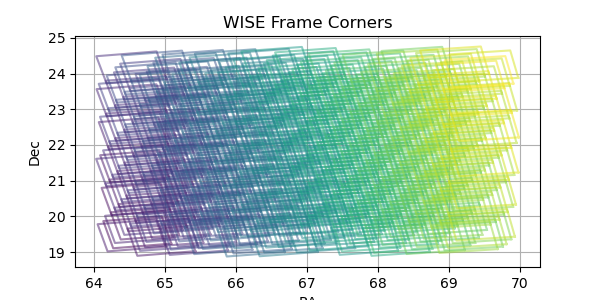

In [80]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import viridis

all_mjds = np.array([frame[3] for frame in search_frames])

norm = Normalize(vmin=all_mjds.min(), vmax=all_mjds.max())
scaler = viridis

plt.figure(figsize=(6, 3))

for id in search_frames[0:]:
    frame_num = id[0]
    ra = id[4:12:2]
    dec = id[5:12:2]
    mjd = id[3]

    color = scaler(norm(mjd))

    plt.plot(ra + [ra[0]], dec + [dec[0]], label=f'Frame {frame_num}', c=color, alpha=0.5)

plt.xlabel('RA')
plt.ylabel('Dec')
plt.title('WISE Frame Corners')
# plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=scaler), label='MJD')
plt.grid(True)
plt.show()

(array([ 47., 108., 109., 115.,  98.]),
 array([59821., 59822., 59823., 59824., 59825., 59826.]),
 <BarContainer object of 5 artists>)

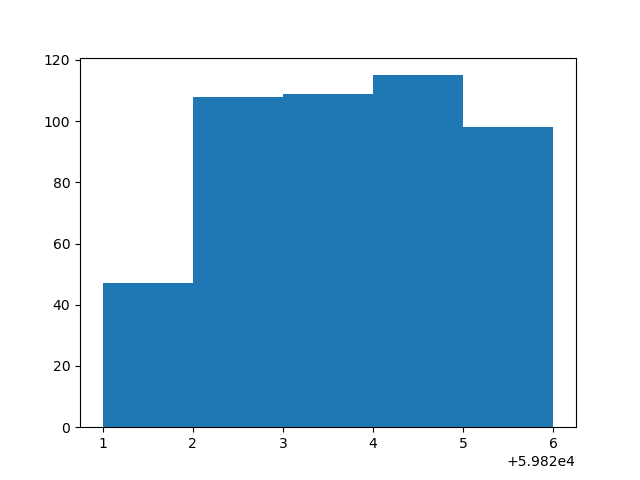

In [81]:
mjds = [int(s[3]) for s in search_frames]
plt.figure()
plt.hist(mjds, bins=5)
# plt.close()

In [82]:
urllist = URL_list(search_frames)
# urllist

In [84]:
def get_single_file_url(scan_id, scangrp, frame_num):

    irsa_url = "%s/%s/%03d/" % (scangrp, scan_id, frame_num)

    filename = f"{scan_id:s}{frame_num:03d}-w2-int-1b.fits"

    irsa_url = f'https://irsa.ipac.caltech.edu/ibe/data/wise/neowiser/p1bm_frm/{irsa_url}/{filename}'
    
    return irsa_url

#----------------------------------------------------------------------------------------------------------------------------

def URL_list(megalist):
    urllist = []
    for i in megalist:
        url = get_single_file_url(i[1], i[2], int(i[0]))
        urllist.append(url)
    return urllist

urllist = URL_list(search_frames)

#----------------------------------------------------------------------------------------------------------------------------

def old_maskImage(path, showImage=False):
    single_path = path
    im_single = fix_byte_order(fits.getdata(single_path))

    s_bkg, s_rms = kli.background.measure_bkg_and_rms(im_single, meas_window_size=[10]*2, outlier_sigma=3, blur_sigma=20, blur_kernel_size=31, device='cpu')
    im_single_br = im_single - s_bkg # Bkg removal
    
    im_single_c = kli.nan_infill(im_single_br, s_rms)

    # im_sg_br / s_rms - > noise normalized
    
    im_coadd = kli.wise.make_wise_coadd(single_path)
    
    c_bkg, c_rms = kli.background.measure_bkg_and_rms(im_coadd, meas_window_size=[10]*2, outlier_sigma=3, blur_sigma=20, blur_kernel_size=31, device='cpu')
    im_coadd_br = im_coadd - c_bkg # Bkg removal
    
    c_obj_map = im_coadd_br > 0.5
    
    c_obj_map = binary_dilation(binary_erosion(c_obj_map, iterations=1), iterations=2)

    
    # Fill single with NaN where objects found in the coadd
    im_single_masked = im_single_c.copy()
    im_single_masked[c_obj_map] = np.nan
    
    # Measure single bkg and RMS
    
    s_bkg, s_rms = kli.background.measure_bkg_and_rms(
        im_single_masked, meas_window_size=[10]*2, outlier_sigma=3, 
        blur_sigma=20, blur_kernel_size=31, device='cpu',
    )
    # Remove single bkg
    s_b = im_single_masked - s_bkg
    # Infill single NaNs with noise
    s_i = kli.nan_infill(s_b, s_rms)

    #--------------------------------------------------------------------------------------------------------------------------------------------------------
    constant_scaler = 5

    s_norm = s_i.copy()

    low_px_mask = s_norm < -3*s_rms

    s_norm[low_px_mask] = np.nan
    
    s_norm = kli.nan_infill(s_norm, s_rms)
    
    s_norm /= (s_rms * constant_scaler)


    #--------------------------------------------------------------------------------------------------------------------------------------------------------

    if showImage:
        axs = plot_images(
            ims=[im_single_c, s_i, im_coadd], 
            title=None, norm_same=False, fig_height=4, 
            norm_kwargs=dict(min_cut=-1, max_cut=1000), 
            imshow_kwargs=dict(cmap='viridis')
        )
        [ax.set_title(t) for ax, t in zip(axs, ['Single', 'Masked Single', 'Coadd'])];

    return s_norm, im_coadd, im_single


import numpy as np
from PIL import Image

def grid_image(image_array, square_size):
    corners = []
    # Convert the image array to a PIL image
    image = Image.fromarray(image_array)

    # Get the size of the original image
    width, height = image.size

    # Calculate the number of squares in both dimensions
    num_squares_x = width // square_size
    num_squares_y = height // square_size

    squares = []
    # Loop through the image and crop it into smaller squares
    for i in range(num_squares_x):
        for j in range(num_squares_y):
            left = i * square_size
            upper = j * square_size
            right = (i + 1) * square_size
            lower = (j + 1) * square_size

            # Crop the square
            square = image.crop((left, upper, right, lower))
            # if left == 0:
            #     print(left, upper, right, lower)
            
            # Convert the square to a NumPy array and append to the list
            square_array = np.array(square)
            squares.append(square_array)

            # midpt = midpoint(left, upper, right, lower)
            corners.append([left,upper])
            # print("corner: ", left, upper)

    return squares, corners

In [86]:
def maskImage(path, showImage=False):
    single_path = path
    im_single = fix_byte_order(fits.getdata(single_path))

    s_bkg, s_rms = kli.background.measure_bkg_and_rms(im_single, meas_window_size=[10]*2, outlier_sigma=3, blur_sigma=20, blur_kernel_size=31, device='cpu')
    im_single_br = im_single - s_bkg # Bkg removal
    
    im_single_c = kli.nan_infill(im_single_br, s_rms)

    
    im_coadd = kli.wise.make_wise_coadd(single_path)
    
    c_bkg, c_rms = kli.background.measure_bkg_and_rms(im_coadd, meas_window_size=[10]*2, outlier_sigma=3, blur_sigma=20, blur_kernel_size=31, device='cpu')
    im_coadd_br = im_coadd - c_bkg # Bkg removal
    
    c_obj_map = im_coadd_br > 0.5
    
    c_obj_map = binary_dilation(binary_erosion(c_obj_map, iterations=1), iterations=2)

    
    # Fill single with NaN where objects found in the coadd
    im_single_masked = im_single_c.copy()
    im_single_masked[c_obj_map] = np.nan
    
    # Measure single bkg and RMS
    
    s_bkg, s_rms = kli.background.measure_bkg_and_rms(
        im_single_masked, meas_window_size=[10]*2, outlier_sigma=3, 
        blur_sigma=20, blur_kernel_size=31, device='cpu',
    )
    # Remove single bkg
    s_b = im_single_masked - s_bkg
    # Infill single NaNs with noise
    s_i = kli.nan_infill(s_b, s_rms)

    #--------------------------------------------------------------------------------------------------------------------------------------------------------

    constant_scaler = 5

    s_norm = s_i.copy()

    low_px_mask = s_norm < -3 * s_rms

    s_norm[low_px_mask] = np.nan
    
    s_norm = kli.nan_infill(s_norm, s_rms)
    
    s_norm /= (s_rms * constant_scaler)


    #--------------------------------------------------------------------------------------------------------------------------------------------------------

    if showImage:
        axs = plot_images(
            ims=[im_single_c, s_norm, s_i, im_coadd], 
            title=None, norm_same=False, fig_height=4, 
            # norm_kwargs=dict(min_cut=-100, max_cut=1000), 
            imshow_kwargs=dict(cmap='viridis')
        )
        [ax.set_title(t) for ax, t in zip(axs, ['Single', 'Masked Single', 'Coadd'])];

    return s_norm, im_coadd, im_single


In [118]:
len(urllist)

477

In [124]:
from kevlib.utils.io import mmcreate, mmload

grids = []
topcorners = []
coadds = []
bitmasks = []
singles = []
i = 92
for url in tqdm(urllist[92:]): 
    
    print("On frame " , i)
    
    m, coadd, single = maskImage(url)
    
    squares, corners = grid_image(m, square_size=15)

    bitmask_url = url[:87] + "w2-msk-1b.fits.gz"
    bmask = fits.open(bitmask_url)
    bmask = bmask[0].data
    b_grid, _ = grid_image(bmask, 15)

    grids.append(squares)
    maxes = [np.max(s) for s in squares]

    bitmasks.append(b_grid)

    i+=1

  0%|          | 0/385 [00:00<?, ?it/s]

On frame  92
On frame  93
On frame  94
On frame  95
On frame  96
On frame  97
On frame  98
On frame  99
On frame  100
On frame  101
On frame  102
On frame  103
On frame  104
On frame  105
On frame  106
On frame  107
On frame  108


URLError: <urlopen error _ssl.c:985: The handshake operation timed out>

In [127]:
# plot_images(bmask)

In [123]:

print("finished main loop")

# all_urls = []
# for i in urllist:
#     all_urls.append(i)

imgs = [i for a in grids for i in a]
bitmasks_g = [i for a in bitmasks for i in a]
final_grids = []


for i in tqdm(range(len(imgs))):
    
    im, c = remove_artifacts(np.array(bitmasks_g[i]), imgs[i])
    final_grids.append(im)
    if (np.max(im) == 0.0):
        print("empty image detected")
        break

np.save("./TrainingData/TrueSet/Final_True_Bkg_parts/p1_f_0to92_grids_final.npy", final_grids)

finished main loop


  0%|          | 0/412988 [00:00<?, ?it/s]

In [112]:
g = np.load("./TrainingData/TrueSet/TrueBkgParts/p1_30f_FinalGrids.npy")
g.shape

(134670, 15, 15)

In [1]:
x = 100
plot_images([g[x], final_grids[x]])

In [3]:
# all_urls = []
# for i in urllist:
#     all_urls.append(i)

# imgs = [i for a in grids for i in a]
# bitmasks_g = [i for a in bitmasks for i in a]

# print("started creating npy files")

# dep = mmcreate("./TrainingData/TrueSet/TrueBkgParts/p1_30f_grids.npy", dtype=float, shape=(len(imgs), 15, 15), fill_value=0)
# dep.flush()

# bit = mmcreate("./TrainingData/TrueSet/TrueBkgParts/p1_30f_bit.npy", dtype=float, shape=(len(imgs), 15, 15), fill_value=0)
# bit.flush()

# finaldep = mmcreate("./TrainingData/TrueSet/TrueBkgParts/p1_30f_FinalGrids.npy", dtype=float, shape=(len(imgs), 15, 15), fill_value=0)
# finaldep.flush()

# print("starting to save data")

# for i in tqdm(range(len(dep))):
#     dep[i, :, :] = imgs[i]
#     bit[i, :, :] = bitmasks_g[i]
    
#     im, c = remove_artifacts(np.array(bit[i]), dep[i])
#     finaldep[i, :, :] = im
#     if (np.max(im) == 0.0):
#         print("empty image detected")
#         break
    
#     dep.flush()
#     bit.flush()
#     finaldep.flush()

In [32]:
# all_urls = []
# for u in urllist:
#     for i in range(4489):
#         all_urls.append(u)

# np.save("./Searches/Mar19_Search_URLs_recoveredapr5", all_urls)

In [33]:
len(all_urls)

3389195

# Filter out bitmask patterns

In [29]:
finaldep = mmcreate("./Searches/Mar19_Search_DarkPixelsRemoved_Normalized_FinalDeployBitArtifactCleaned.npy", dtype=float, shape=(len(deploy_samples), 15, 15), fill_value=0)
finaldep.flush()

for i in tqdm(range(len(bitmasks_g))):
    im, c = remove_artifacts(np.array(bit[i]), dep[i])
    finaldep[i, :, :] = im

  0%|          | 0/3389195 [00:00<?, ?it/s]

In [150]:
np.save("./searchGrids", clean_bkgs)
# np.save("./Deploys/coadds", coadds)
# np.save("./Deploys/bitmasks", bitmasks)


In [31]:
# finaldep[0]

In [27]:
len(falses)

248900

In [13]:
synth = np.load("../TrainingData/104k_TrueImages_First200kof100CleanedFrames_SNR3to7.npy")

real = np.load("../TestingData/141RealDimAstImages.npy")